In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
import scipy.sparse
import time
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn
import wordcloud
import matplotlib

In [2]:
libraries = {
    'pandas': pd,
    'numpy': np,
    'matplotlib': matplotlib,
    'seaborn': sns,
    'scipy': scipy,
    'scikit-learn': sklearn,
    'wordcloud': wordcloud
}

content_to_write = ''
for lib, module in libraries.items():
    version = module.__version__
    content_to_write += f"{lib}=={version}\n"

# Write to a README.txt file
with open('../README.txt', 'w') as f:
    f.write(content_to_write)


### Load Dataset

In [3]:
ratings = pd.read_csv('../Input/ratings.csv')
ratings.head()

,userId,movieId,rating,tstamp
0,206,4803,4.0,2003-04-07 13:52:01
1,5073,72731,4.0,2020-02-19 16:07:53
2,4739,91653,4.0,2020-12-28 15:35:58
3,535,3005,3.0,2008-12-26 05:38:11
4,465,4776,3.0,2008-08-13 20:22:36


In [4]:
movies = pd.read_csv('../Input/movies.csv')
movies_ = movies.copy()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## EDA

### Data Exploration

In [5]:
# check the shape
print(ratings.shape)
print(movies.shape)

(3908657, 4)
(62423, 3)


In [6]:
# check if has missing value
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId     0
movieId    0
rating     0
tstamp     0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


In [7]:
print(ratings.info())
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3908657 entries, 0 to 3908656
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   tstamp   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 119.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


In [8]:
# check if has duplicated data
print(ratings[ratings.duplicated()])
print(movies[movies.duplicated()])

Empty DataFrame
Columns: [userId, movieId, rating, tstamp]
Index: []
Empty DataFrame
Columns: [movieId, title, genres]
Index: []


In [9]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,3908657.0,2434.060851,1950.445219,1.0,727.0,1973.0,3858.0,6724.0
movieId,3908657.0,62535.529829,67051.572745,1.0,3478.0,45447.0,106002.0,270592.0
rating,3908657.0,3.419320,1.022044,0.5,3.0,3.5,4.0,5.0


### Data Process

In [10]:
movies['genres'] = movies['genres'].apply(lambda x : x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [11]:
# Merging ratings and movies data
movie_data = pd.merge(ratings, movies, on='movieId')
movie_data = movie_data.drop(columns='tstamp')
movie_data.head()

,userId,movieId,rating,title,genres
0,206,4803,4.0,Play Misty for Me (1971),"[Drama, Thriller]"
1,201,4803,3.0,Play Misty for Me (1971),"[Drama, Thriller]"
2,3698,4803,3.0,Play Misty for Me (1971),"[Drama, Thriller]"
3,104,4803,1.0,Play Misty for Me (1971),"[Drama, Thriller]"
4,12,4803,4.0,Play Misty for Me (1971),"[Drama, Thriller]"


In [12]:
print('# movies: %d' % len(movie_data))
movie_ratings_count = movie_data.groupby('movieId').size()
# fiter ratings_counts more than 50
popular_movies = movie_ratings_count[movie_ratings_count >= 50].index
filtered_movie_data = movie_data[movie_data['movieId'].isin(popular_movies)]
print('# At least 50 movie ratingst: %d' % len(filtered_movie_data))

# movies: 3756004
# At least 50 movie ratingst: 3409871


In [13]:
# create a new dataframe to show the title, rating, rating_counts
ratings_mean = pd.DataFrame(filtered_movie_data.groupby('title')['rating'].mean())
ratings_mean['rating_counts'] = pd.DataFrame(filtered_movie_data.groupby('title')['rating'].count())
ratings_mean['rating_sum'] = pd.DataFrame(filtered_movie_data.groupby('title')['rating'].sum())
ratings_mean.sort_values(by='rating', ascending=False).head()

,rating,rating_counts,rating_sum
title,,,
Planet Earth II (2016),4.472727,660,2952.0
Planet Earth (2006),4.415816,980,4327.5
Band of Brothers (2001),4.384065,979,4292.0
"Human Condition III, The (Ningen no joken III) (1961)",4.372549,51,223.0
"Shawshank Redemption, The (1994)",4.350253,4945,21512.0


### Data Visualization

rating_group
1-2      13272
2-3     482329
3-4    2650244
4-5     264026
Name: rating_counts, dtype: int64


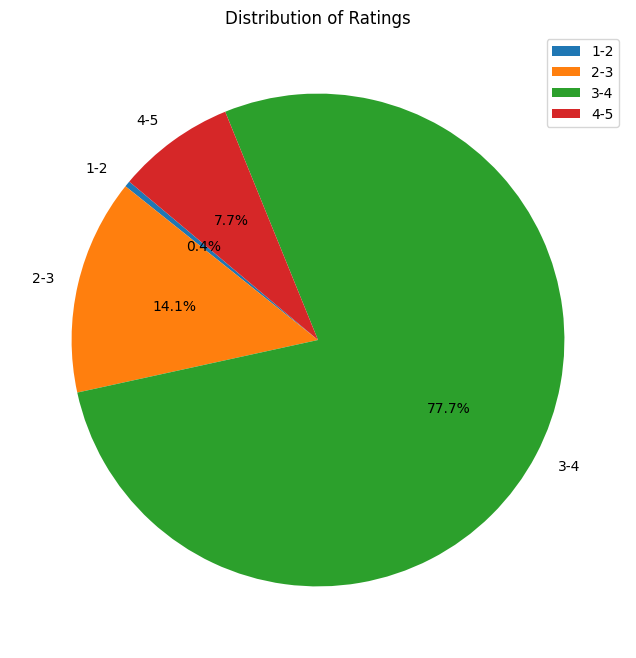

In [14]:
# the proportion of movie ratings
bins = [i for i in range(6)]
labels = ['0-1','1-2','2-3','3-4','4-5']
ratings_mean['rating_group'] = pd.cut(ratings_mean['rating'], bins=bins, labels=labels, include_lowest=True)

# Group by rating group and calculate the sum of rating counts
rating_counts_grouped = ratings_mean.groupby('rating_group',observed=True)['rating_counts'].sum()
print(rating_counts_grouped)

plt.figure(figsize=(8, 8))
plt.pie(rating_counts_grouped, labels=rating_counts_grouped.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ratings')
plt.legend()
plt.show()

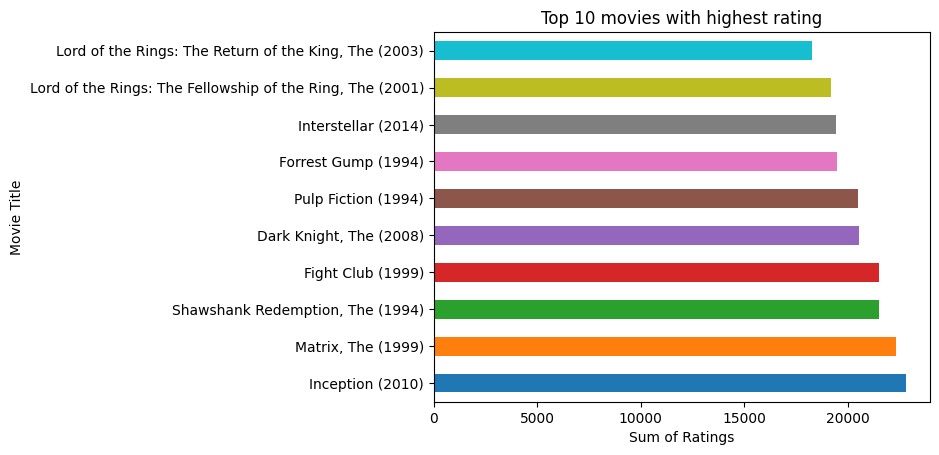

In [15]:
# the top10 rating movies
top10_rating_movies = ratings_mean['rating_sum'].sort_values(ascending=False)[:10]
colors = plt.cm.tab10.colors[:len(top10_rating_movies)]

top10_rating_movies.plot(kind='barh', color=colors)

plt.title('Top 10 movies with highest rating')
plt.xlabel('Sum of Ratings')
plt.ylabel('Movie Title')
plt.show()

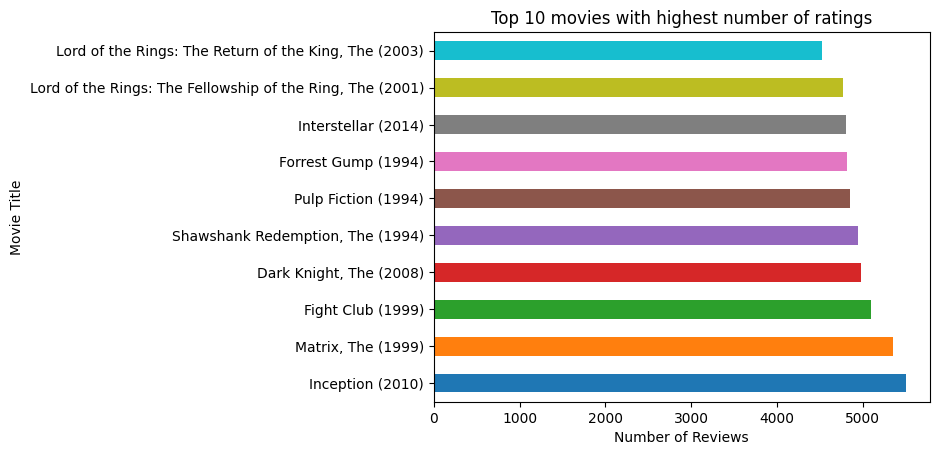

In [16]:
# the top10 highest count movies
top10_count_movies = ratings_mean['rating_counts'].sort_values(ascending=False)[:10]
colors = plt.cm.tab10.colors[:len(top10_count_movies)]

top10_count_movies.plot(kind='barh', color=colors)

plt.title('Top 10 movies with highest number of ratings')
plt.xlabel('Number of Reviews')
plt.ylabel('Movie Title')
plt.show()

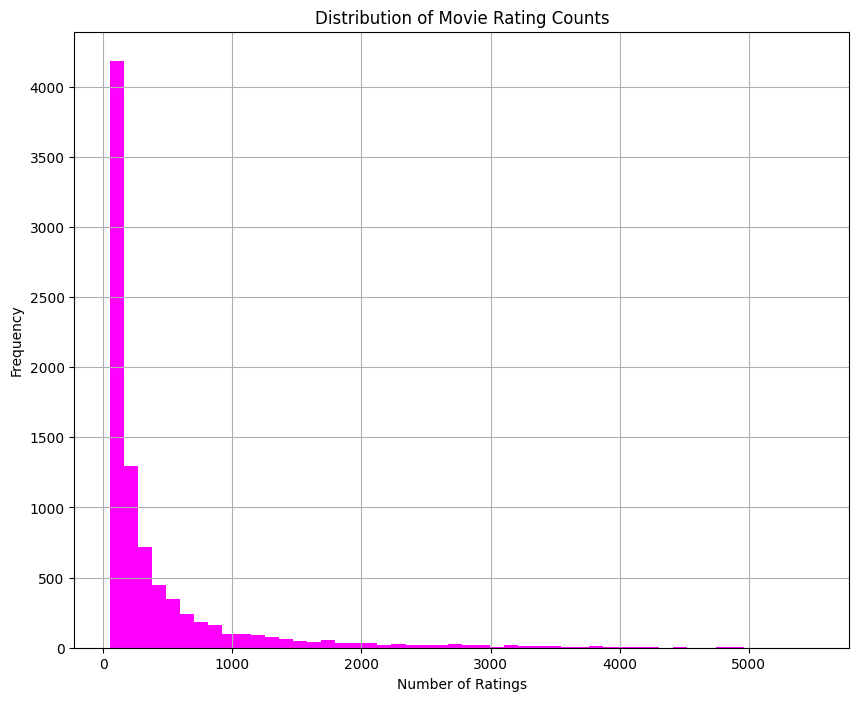

In [17]:
plt.figure(figsize=(10,8))
ratings_mean['rating_counts'].hist(bins=50,color='#FF00FF')
plt.title('Distribution of Movie Rating Counts')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

plt.show()

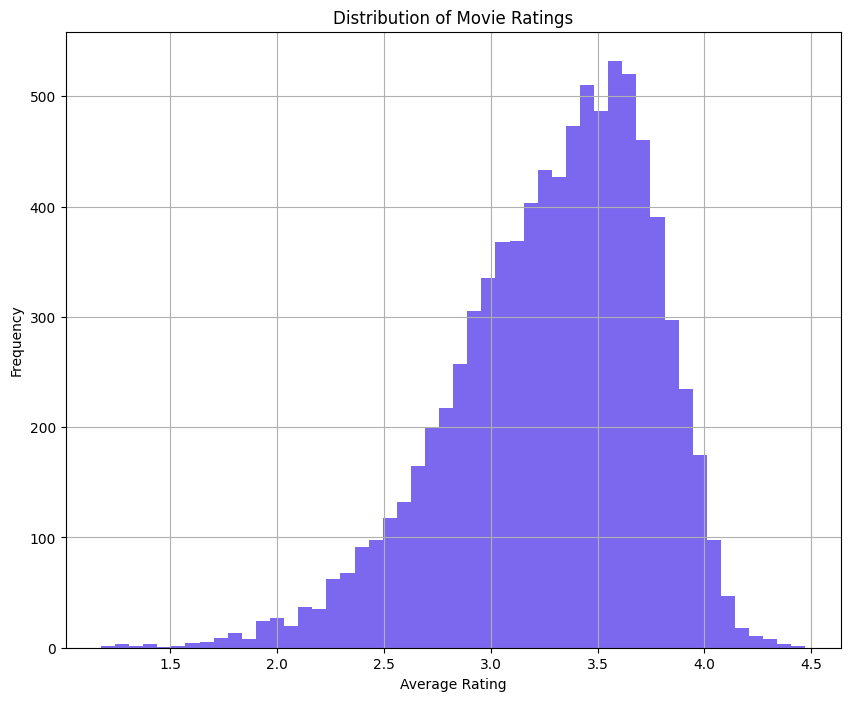

In [18]:
plt.figure(figsize=(10,8))
ratings_mean['rating'].hist(bins=50,color='#7B68EE')

plt.title('Distribution of Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x800 with 0 Axes>

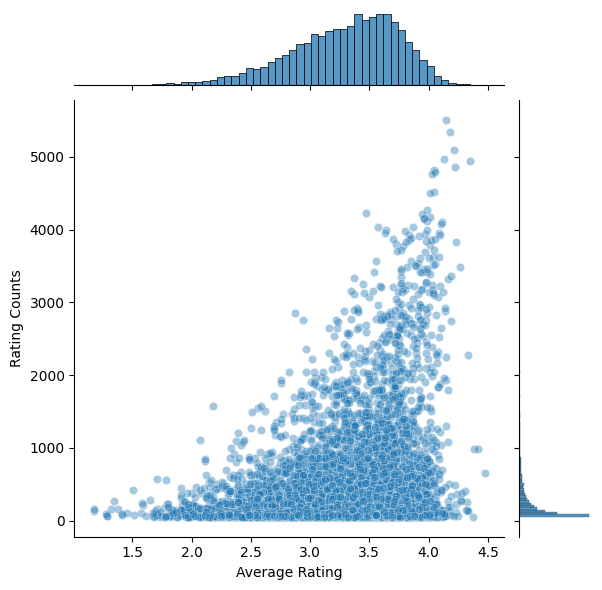

In [19]:
plt.figure(figsize=(10,8))
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean, alpha=0.4)

# plt.title('Relationship between Average Rating and Rating Counts')
plt.xlabel('Average Rating')
plt.ylabel('Rating Counts')
plt.show()

In [20]:
# used for wordcloud graph
genres=list(set([genre for genre_list in movies['genres'] for genre in genre_list]))
# remove '(no genres listed)'
genres.remove('(no genres listed)')
movie_titles = [title[:-7] for title in movies['title']]

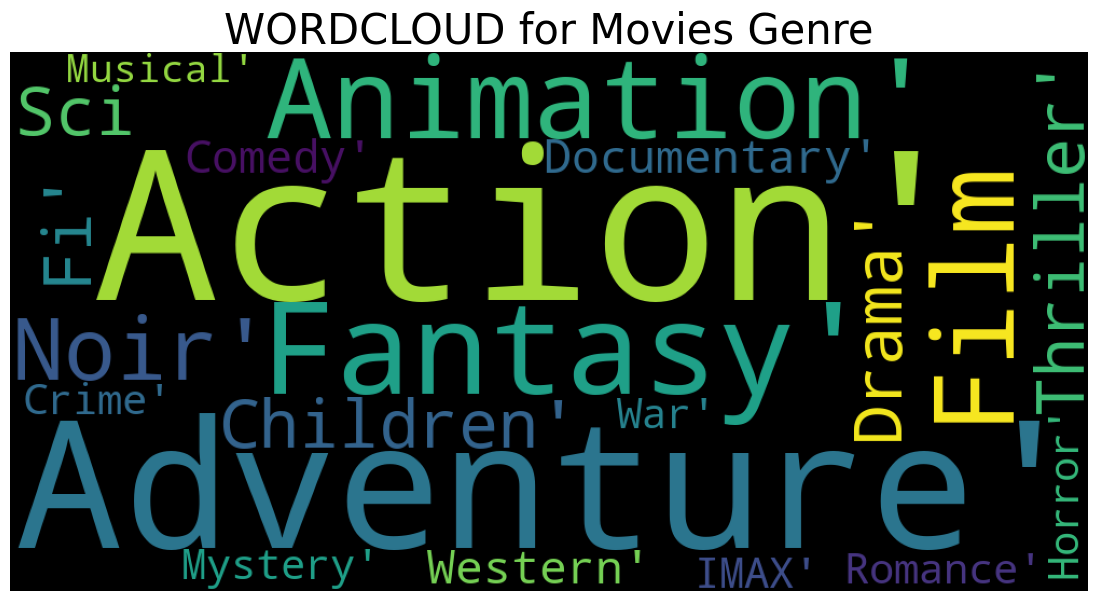

In [21]:
wordcloud_genre=WordCloud(width=1000,height=500,background_color='black',min_font_size=2
                    ,min_word_length=3).generate(str(genres))

plt.figure(figsize=(20,7))
plt.axis('off')
plt.title('WORDCLOUD for Movies Genre',fontsize=30)
plt.imshow(wordcloud_genre)

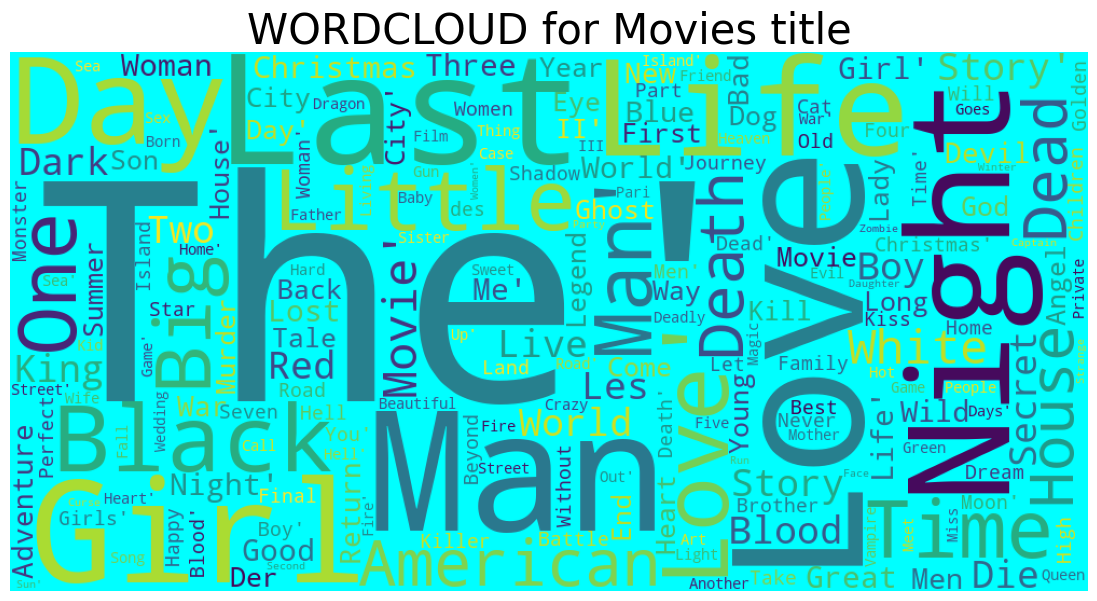

In [22]:
wordcloud_title=WordCloud(width=1000,height=500,background_color='cyan',min_font_size=2
                    ,min_word_length=3).generate(str(movie_titles))

plt.figure(figsize=(20,7))
plt.axis('off')
plt.title('WORDCLOUD for Movies title',fontsize=30)
plt.imshow(wordcloud_title)

## Modeling

In [23]:
X_train, X_test = train_test_split(filtered_movie_data, test_size=0.3, random_state=42)
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (2386909, 5)
X_test.shape: (1022962, 5)


In [24]:
dummy_train = X_train.copy()
dummy_test = X_test.copy()
# some movies have been rated, then set 0
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>0 else 1)
# As opposed to the one above
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>0 else 0)

dummy_train = dummy_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(1)
dummy_test = dummy_test.pivot(index ='userId', columns = 'movieId', values = 'rating').fillna(0)
dummy_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,207890,208040,208096,208110,208715,208737,208747,208773,208813,208939
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
user_data = X_train.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,207890,208040,208096,208110,208715,208737,208747,208773,208813,208939
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,3.0,0.0,4.5,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User-based collaborative filtering

In [26]:
user_start_time = time.time()
user_similarity = cosine_similarity(user_data)
user_similarity[np.isnan(user_similarity)] = 0
print(user_similarity)
print('- '*10)
print(user_similarity.shape)

[[1.         0.2157621  0.12812291 ... 0.07759321 0.08962526 0.08148425]
 [0.2157621  1.         0.14705552 ... 0.06963207 0.1085028  0.11635261]
 [0.12812291 0.14705552 1.         ... 0.01904439 0.11938205 0.1145834 ]
 ...
 [0.07759321 0.06963207 0.01904439 ... 1.         0.10686266 0.06424515]
 [0.08962526 0.1085028  0.11938205 ... 0.10686266 1.         0.17617765]
 [0.08148425 0.11635261 0.1145834  ... 0.06424515 0.17617765 1.        ]]
- - - - - - - - - - 
(6723, 6723)


In [27]:
# predict the movies'rating
user_predicted_ratings = np.dot(user_similarity, user_data)
print(user_predicted_ratings)
print(user_predicted_ratings.shape)

[[1166.45814134  572.28731801   94.49329617 ...   53.88288515
    30.63771285  245.67841067]
 [1407.81190424  708.7586942   103.28418416 ...   57.97951873
    32.59551856  278.75105886]
 [1286.84252583  628.28996906   87.01563524 ...   57.3760476
    26.03830111  253.22338033]
 ...
 [1065.97140269  505.2645594    53.95031522 ...   55.73851503
    18.334961    220.44951503]
 [1414.97011614  661.47031665   78.55089658 ...   71.00539287
    25.32802418  282.63505164]
 [1846.57853904  906.09325942   97.14037112 ...   81.51875908
    43.47644593  396.79730083]]
(6723, 8511)


In [28]:
user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_end_time = time.time()
user_final_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,207890,208040,208096,208110,208715,208737,208747,208773,208813,208939
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,572.287318,0.000000,23.979602,0.000000,570.827812,0.000000,15.121022,38.470478,364.701943,...,15.646359,24.465905,32.195816,23.070151,25.082647,60.159729,52.338944,53.882885,30.637713,245.678411
2,0.000000,708.758694,103.284184,23.353413,139.932273,700.499817,118.679363,16.345159,44.809860,444.315103,...,18.324492,24.596387,33.011112,22.557281,26.270129,70.476504,57.056050,57.979519,32.595519,278.751059
3,0.000000,628.289969,87.015635,19.451627,111.098739,627.466493,96.747407,14.494013,37.787947,404.029810,...,15.047332,22.084869,27.617345,21.576716,19.635626,56.545081,45.366823,57.376048,26.038301,253.223380
4,0.000000,793.637034,113.491401,26.365944,0.000000,848.264417,128.736691,18.404532,49.548997,517.283827,...,20.062904,30.962131,36.594950,27.479536,26.057114,75.443649,61.611269,75.466622,33.325615,318.466705
5,1376.148172,0.000000,134.488274,31.854679,157.731088,0.000000,140.051943,20.175175,0.000000,0.000000,...,23.676204,28.535848,40.529018,26.452168,22.478623,92.957521,72.879317,63.122507,31.631999,257.451895


In [29]:
user_final_ratings.iloc[10].sort_values(ascending = False).head()

movieId
79132    2358.473398
2959     2239.636446
4993     2086.473491
7153     2032.030806
60069    1792.407294
Name: 11, dtype: float64

In [30]:
# for instance
# recommend top5 movies to userId=10
user_recommend_movies = user_final_ratings.iloc[10].sort_values(ascending = False).head()
top_movies = movies[movies['movieId'].isin(user_recommend_movies.index)][['movieId', 'title']]
print('Top 5 movie recommendations for User 10:')

for movie_id, movie_title in zip(top_movies['movieId'], top_movies['title']):
    print(f"Movie ID: {movie_id}, Title: {movie_title}")

Top 5 movie recommendations for User 10:
Movie ID: 2959, Title: Fight Club (1999)
Movie ID: 4993, Title: Lord of the Rings: The Fellowship of the Ring, The (2001)
Movie ID: 7153, Title: Lord of the Rings: The Return of the King, The (2003)
Movie ID: 60069, Title: WALL·E (2008)
Movie ID: 79132, Title: Inception (2010)


In [31]:
def align_matrices(actual, predicted):
    # Get unique user and movie indices
    user_indices = np.union1d(actual.index, predicted.index)
    movie_indices = np.union1d(actual.columns, predicted.columns)
    actual_aligned = actual.reindex(index=user_indices, columns=movie_indices, fill_value=0)
    predicted_aligned = predicted.reindex(index=user_indices, columns=movie_indices, fill_value=0)
    
    return actual_aligned, predicted_aligned

# Calculate RMSE
def calculate_rmse(actual, predicted):
    mse = mean_squared_error(actual.values.flatten(), predicted.values.flatten())
    rmse = np.sqrt(mse)
    return rmse

# Calculate MAE
def calculate_mae(actual, predicted):
    mae = mean_absolute_error(actual.values.flatten(), predicted.values.flatten())
    return mae


In [32]:
user_actual_ratings, user_predicted_ratings = align_matrices(dummy_test, user_final_ratings)
print('User-based Collaborative filtering')
# Calculate RMSE
u_rmse = calculate_rmse(user_actual_ratings, user_predicted_ratings)
print(f'RMSE: {u_rmse}')

# Calculate MAE
u_mae = calculate_mae(user_actual_ratings, user_predicted_ratings)
print(f'MAE: {u_mae}')
user_execution_time = user_end_time - user_start_time
print(f'User-based Execution time:',user_execution_time)

User-based Collaborative filtering
RMSE: 269.1837693758705
MAE: 134.11883676254868
User-based Execution time: 23.85502815246582


### Item-based collaborative filtering

In [33]:
movie_features = X_train.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6715,6716,6717,6718,6719,6720,6721,6722,6723,6724
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,4.0,5.0,0.0,4.0,0.0,0.0,4.0,2.5,...,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,3.0,0.0,2.5,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
item_start_time = time.time()
item_similarity = cosine_similarity(movie_features)
item_similarity[np.isnan(item_similarity)] = 0
print(item_similarity)
print('- '*10)
print(item_similarity.shape)

[[1.         0.40389708 0.18043234 ... 0.1213453  0.08908057 0.22813075]
 [0.40389708 1.         0.14491844 ... 0.09372162 0.08293381 0.20881718]
 [0.18043234 0.14491844 1.         ... 0.05160476 0.05245923 0.06460393]
 ...
 [0.1213453  0.09372162 0.05160476 ... 1.         0.03625098 0.12030302]
 [0.08908057 0.08293381 0.05245923 ... 0.03625098 1.         0.08391244]
 [0.22813075 0.20881718 0.06460393 ... 0.12030302 0.08391244 1.        ]]
- - - - - - - - - - 
(8511, 8511)


In [35]:
item_predicted_ratings = np.dot(movie_features.T, item_similarity)
print(item_predicted_ratings)
print(item_predicted_ratings.shape)

[[519.57797375 407.20600277 340.88058504 ... 143.09047535 133.14575585
  248.98614261]
 [262.3506296  219.55837844 148.58960396 ...  62.55333921  61.33191305
  120.55276964]
 [211.87352459 172.32989565 112.31748153 ...  54.509494    41.06718228
   95.31746188]
 ...
 [ 46.57714659  36.80397829  16.74500531 ...  13.36581744   7.58602756
   22.02572658]
 [134.53166414 103.91088678  53.64997792 ...  38.30660053  21.65832097
   60.54704978]
 [219.61143062 180.46270993  80.38577367 ...  54.53296937  47.39436894
  108.28991436]]
(6723, 8511)


In [36]:
item_final_ratings = np.multiply(item_predicted_ratings, dummy_train)
item_end_time = time.time()
item_final_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,207890,208040,208096,208110,208715,208737,208747,208773,208813,208939
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,407.206003,0.000000,229.959073,0.000000,414.531584,0.000000,131.310355,199.174592,408.643314,...,86.808088,120.766644,186.870882,155.871240,109.115511,179.506979,197.222132,143.090475,133.145756,248.986143
2,0.000000,219.558378,148.589604,88.438661,160.577797,209.551943,150.459287,59.046473,98.627383,205.204996,...,43.970640,43.823031,70.447412,55.129346,50.730171,88.171715,88.750477,62.553339,61.331913,120.552770
3,0.000000,172.329896,112.317482,64.790763,111.749843,167.748245,109.879395,47.579233,72.357918,168.612797,...,31.098214,35.252394,52.048382,47.840648,31.298163,61.860830,60.450269,54.509494,41.067182,95.317462
4,0.000000,290.423944,193.000343,117.499554,0.000000,304.603951,194.815716,78.767787,123.464006,287.448502,...,53.380401,68.814663,93.009998,80.742923,54.982251,108.803474,110.954608,96.750878,69.966409,161.528265
5,792.978928,0.000000,601.292870,363.029109,556.876091,0.000000,555.822267,224.733321,0.000000,0.000000,...,179.037587,160.837113,286.381534,207.492708,129.449306,372.089430,355.898381,202.245169,186.693468,338.628565


In [37]:
item_final_ratings.iloc[10].sort_values(ascending = False).head()

movieId
2716     497.925559
4993     490.809922
1210     488.800089
6377     487.256486
33794    487.252680
Name: 11, dtype: float64

In [38]:
# for instance
# recommend top5 movies to userId=10
item_recommend_movies = item_final_ratings.iloc[10].sort_values(ascending = False).head()
top_movies_item = movies[movies['movieId'].isin(item_recommend_movies.index)][['movieId', 'title']]
print('Top 5 movie recommendations for User 10:')

for movie_id, movie_title in zip(top_movies_item['movieId'], top_movies_item['title']):
    print(f"Movie ID: {movie_id}, Title: {movie_title}")

Top 5 movie recommendations for User 10:
Movie ID: 1210, Title: Star Wars: Episode VI - Return of the Jedi (1983)
Movie ID: 2716, Title: Ghostbusters (a.k.a. Ghost Busters) (1984)
Movie ID: 4993, Title: Lord of the Rings: The Fellowship of the Ring, The (2001)
Movie ID: 6377, Title: Finding Nemo (2003)
Movie ID: 33794, Title: Batman Begins (2005)


In [39]:
item_actual_ratings, item_predicted_ratings = align_matrices(dummy_test.T, item_final_ratings.T)
print('Item-based Collaborative filtering')
# Calculate RMSE
i_rmse = calculate_rmse(item_actual_ratings, item_predicted_ratings)
print(f'RMSE: {i_rmse}')

# Calculate MAE
i_mae = calculate_mae(item_actual_ratings, item_predicted_ratings)
print(f'MAE: {i_mae}')

# Calculate execution time
item_execution_time = item_end_time - item_start_time
print(f'Item-based Execution time:',item_execution_time)

Item-based Collaborative filtering
RMSE: 170.60675608926263
MAE: 114.12300802444854
Item-based Execution time: 30.010464191436768


### Model-based Collaborative filtering

<center>${R} = U \sum  V^{T}$</center> <br>
where R is user ratings matrix, U is the user “features” matrix, $\sum$ is the diagonal matrix of singular values (essentially weights), and $V^{T}$ is the movie “features” matrix. 
U and $V^{T}$ are orthogonal, and represent different things. U represents how much users “like” each feature and VTrepresents how relevant each feature is to each movie.

In [40]:
user_ratings_mean = np.mean(user_data.values, axis=1)
R_demean = user_data - user_ratings_mean.reshape(-1,1)
R_demean

movieId,1,2,3,4,5,6,7,8,9,10,...,207890,208040,208096,208110,208715,208737,208747,208773,208813,208939
userId,,,,,,,,,,,,,,,,,,,,,
1,3.705851,-0.294149,2.705851,-0.294149,4.205851,-0.294149,4.705851,-0.294149,-0.294149,-0.294149,...,-0.294149,-0.294149,-0.294149,-0.294149,-0.294149,-0.294149,-0.294149,-0.294149,-0.294149,-0.294149
2,2.892551,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,...,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449,-0.107449
3,3.914875,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,...,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125,-0.085125
4,4.851839,-0.148161,-0.148161,-0.148161,2.851839,-0.148161,-0.148161,-0.148161,-0.148161,-0.148161,...,-0.148161,-0.148161,-0.148161,-0.148161,-0.148161,-0.148161,-0.148161,-0.148161,-0.148161,-0.148161
5,-0.491129,2.508871,-0.491129,-0.491129,-0.491129,2.508871,-0.491129,-0.491129,1.508871,2.508871,...,-0.491129,-0.491129,-0.491129,-0.491129,-0.491129,-0.491129,-0.491129,-0.491129,-0.491129,-0.491129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6720,2.966984,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,...,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016,-0.033016
6721,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,...,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779,-0.034779
6722,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,...,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393,-0.014393


In [41]:
model_start_time = time.time()
R_sparse = scipy.sparse.csr_matrix(R_demean)
U, sigma, Vt = svds(R_sparse, k=50)
sigma = np.diag(sigma)

In [42]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
model_end_time = time.time()
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_data.columns)

In [43]:
def recommend_movies(predictions_df, userId, movies_df, original_ratings_df,num_recommendations=5):
    user_row_number = userId -1
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    # Get the user's data and merge in the movie information.
    # user_full = df[df.userId == (userId)].sort_values(['rating'], ascending=False)
    user_data = original_ratings_df[original_ratings_df.userId == (userId)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
                 .sort_values(['rating'], ascending=False))
    print('Recommending UserId={0} the highest {1} predicted ratings movies not already rated.'
          .format(userId, num_recommendations))
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',left_on = 'movieId',right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1])

    return user_full, recommendations

In [44]:
already_rated, predictions = recommend_movies(preds_df,10,movies,ratings)
predictions

Recommending UserId=10 the highest 5 predicted ratings movies not already rated.


,movieId,title,genres
8813,60069,WALL·E (2008),"[Adventure, Animation, Children, Romance, Sci-Fi]"
11355,80906,Inside Job (2010),[Documentary]
7503,45186,Mission: Impossible III (2006),"[Action, Adventure, Thriller]"
1351,2474,"Color of Money, The (1986)",[Drama]
1682,3037,Little Big Man (1970),[Western]


In [45]:
# Evaluation
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=user_data.columns)

def calculate_rmse_mae(predictions_df, actual_df):
    actual = actual_df.values.flatten()
    predicted = predictions_df.values.flatten()
    
    non_zero_mask = actual > 0
    actual = actual[non_zero_mask]
    predicted = predicted[non_zero_mask]
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    
    return rmse, mae


In [46]:
# Calculate RMSE and MAE
print('Model-based Collaborative filtering')
m_rmse, m_mae = calculate_rmse_mae(preds_df, user_data)
print("RMSE:", m_rmse)
print("MAE:", m_mae)
model_execution_time = model_end_time - model_start_time
print(f'Model-based Execution time:',model_execution_time)

Model-based Collaborative filtering
RMSE: 2.4457200069163445
MAE: 2.1990005468570835
Model-based Execution time: 49.49940609931946


### Content-based filtering techniques

In [47]:
genre_popularity = (movies_.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

genres
Drama                 25606
Comedy                16870
Thriller               8654
Romance                7719
Action                 7348
Horror                 5989
Documentary            5605
Crime                  5319
(no genres listed)     5062
Adventure              4145
Name: count, dtype: int64

In [48]:
tfidf_genres = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))

tfidf_matrix = tfidf_genres.fit_transform(movies_['genres'])

print(tfidf_matrix.shape)

(62423, 897)


In [49]:
cosine_sim_movies = cosine_similarity(tfidf_matrix)

cosine_sim_df = pd.DataFrame(cosine_sim_movies, index=movies_['title'], columns=movies_['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

Shape: (62423, 62423)


title,Vándorszínészek (2018),Camion (2012),Robin Williams: Live on Broadway (2002),Cactus Flower (1969),Mi fido di te (2007)
title,,,,,
Toy Story (1995),0.04,0.00,0.08,0.08,0.08
Jumanji (1995),0.00,0.00,0.00,0.00,0.00
Grumpier Old Men (1995),0.21,0.00,0.42,0.42,0.42
Waiting to Exhale (1995),0.51,0.21,0.25,0.25,0.25
Father of the Bride Part II (1995),0.49,0.00,1.00,1.00,1.00
...,...,...,...,...,...
We (2018),0.40,1.00,0.00,0.00,0.00
Window of the Soul (2001),0.00,0.00,0.00,0.00,0.00
Bad Poems (2018),1.00,0.40,0.49,0.49,0.49


In [50]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    '''
    Calculates top 10 movies to recommend based on given movie titles genres
    '''
    # Get the index of the movie that matches the title
    idx_movie = movies.loc[movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:11]
    movie_indices = [i[0] for i in sim_scores_movies]
    return pd.DataFrame(movies[['title','genres']].iloc[movie_indices])

In [51]:
get_recommendations_based_on_genres('Pulp Fiction (1994)')

,title,genres
600,Fargo (1996),"[Comedy, Crime, Drama, Thriller]"
1011,Freeway (1996),"[Comedy, Crime, Drama, Thriller]"
3173,Man Bites Dog (C'est arrivé près de chez vous)...,"[Comedy, Crime, Drama, Thriller]"
4138,Beautiful Creatures (2000),"[Comedy, Crime, Drama, Thriller]"
5891,Confessions of a Dangerous Mind (2002),"[Comedy, Crime, Drama, Thriller]"
6363,"Hard Word, The (2002)","[Comedy, Crime, Drama, Thriller]"
6582,Party Monster (2003),"[Comedy, Crime, Drama, Thriller]"
9115,Freeway II: Confessions of a Trickbaby (1999),"[Comedy, Crime, Drama, Thriller]"
10561,Cul-de-sac (1966),"[Comedy, Crime, Drama, Thriller]"
11434,Body Count (1998),"[Comedy, Crime, Drama, Thriller]"


## Performance

In [52]:
'''
User-based Collaborative filtering
RMSE: 269.1837693758705
MAE: 134.11883676254868
User-based Execution time: 24.219364166259766

Item-based Collaborative filtering
RMSE: 170.60675608926263
MAE: 114.12300802444854
Item-based Execution time: 34.39026427268982

Model-based Collaborative filtering
RMSE: 2.445720006916345
MAE: 2.199000546857083
Model-based Execution time: 51.243430852890015
'''

'\nUser-based Collaborative filtering\nRMSE: 269.1837693758705\nMAE: 134.11883676254868\nUser-based Execution time: 24.219364166259766\n\nItem-based Collaborative filtering\nRMSE: 170.60675608926263\nMAE: 114.12300802444854\nItem-based Execution time: 34.39026427268982\n\nModel-based Collaborative filtering\nRMSE: 2.445720006916345\nMAE: 2.199000546857083\nModel-based Execution time: 51.243430852890015\n'

In [53]:
# Execution_time
labels = ['User-based', 'Item-based', 'Model-based']
rmse_values = [round(value,2) for value in [u_rmse,i_rmse,m_rmse]]
mae_values = [round(value,2) for value in [u_mae,i_mae,m_mae]]
execution_times = [round(time,2) for time in 
                   [user_execution_time,item_execution_time,model_execution_time]]

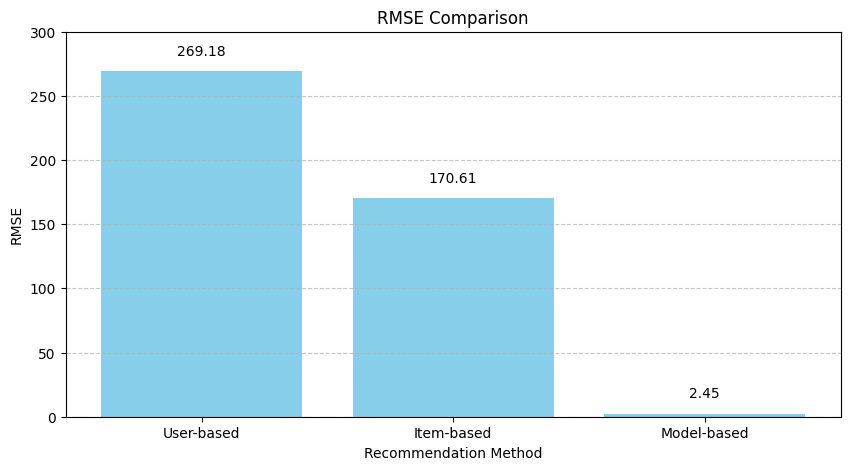

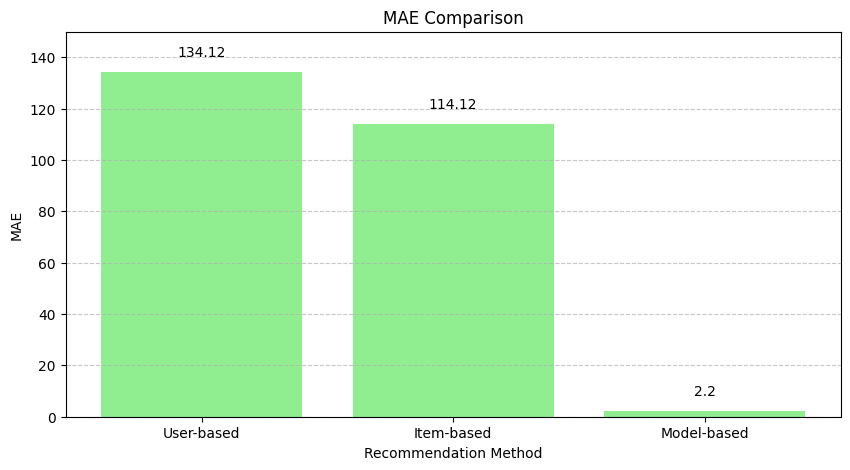

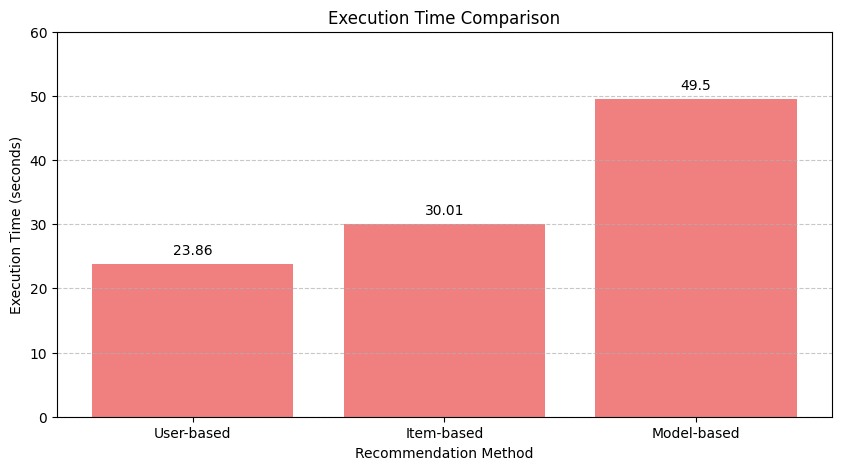

In [54]:
# Plot RMSE
plt.figure(figsize=(10, 5))
plt.bar(labels, rmse_values, color='skyblue')
plt.xlabel('Recommendation Method')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.ylim(0, 300)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(rmse_values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
plt.bar(labels, mae_values, color='lightgreen')
plt.xlabel('Recommendation Method')
plt.ylabel('MAE')
plt.title('MAE Comparison')
plt.ylim(0, 150)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(mae_values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.show()

# Plot Execution Time
plt.figure(figsize=(10, 5))
plt.bar(labels, execution_times, color='lightcoral')
plt.xlabel('Recommendation Method')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(execution_times):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')
plt.show()